# Code to build ML models on the diabetes dataset

In [1]:
# Packages to be installed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For better plots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, \
                            ConfusionMatrixDisplay, RocCurveDisplay, f1_score, precision_score, recall_score, average_precision_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC # Support Vector Machine
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron

# For handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's Pipeline for resampling steps

# For SHAP explanations
import shap
import joblib # For saving models

import plotly.graph_objs as go


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Data Loaded Successfully ---
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null

/var/folders/78/vykvv3p5317_39fydydf88y80000gn/T/ipykernel_31656/3231456401.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis', ax=axes[0])
/var/folders/78/vykvv3p5317_39fydydf88y80000gn/T/ipykernel_31656/3231456401.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette='viridis', ax=axes[1])


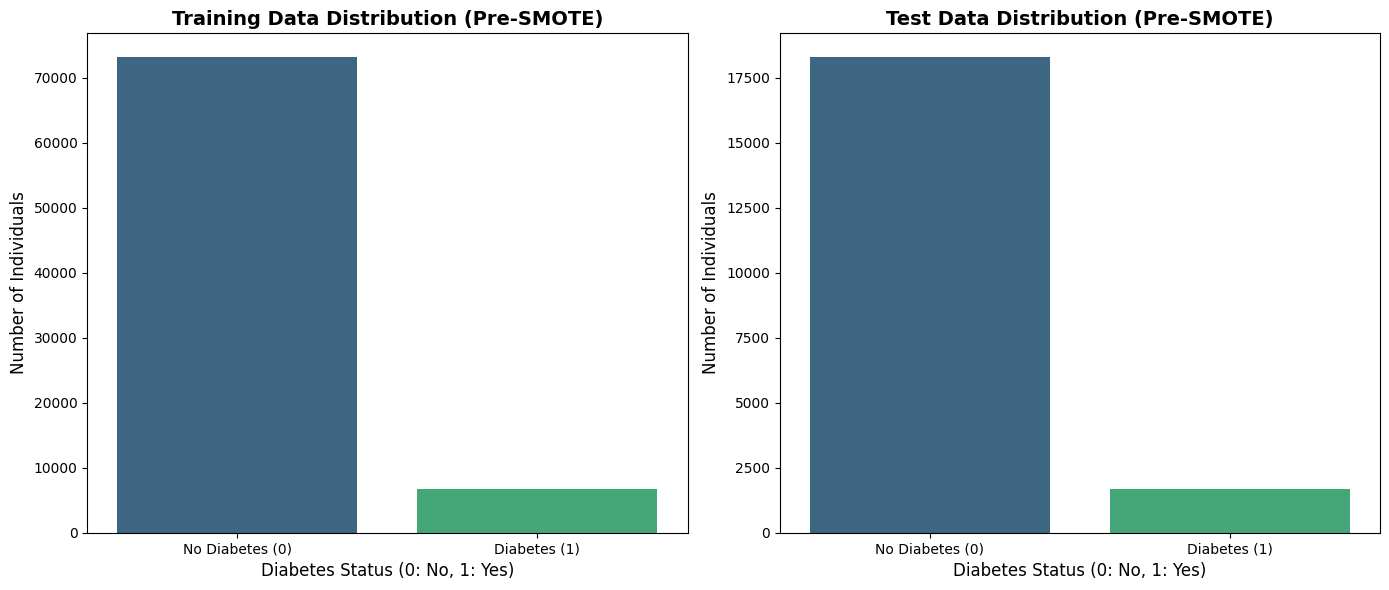


--- Applying Preprocessing and SMOTE to Training Data for Visualization (Post-SMOTE) ---

--- Class Distribution AFTER SMOTE (Training Set Only) ---
Training set distribution AFTER SMOTE:
diabetes
1    73200
0    73200
Name: count, dtype: int64
diabetes
1    50.0%
0    50.0%
Name: proportion, dtype: object


/var/folders/78/vykvv3p5317_39fydydf88y80000gn/T/ipykernel_31656/3231456401.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled_plot, palette='viridis')


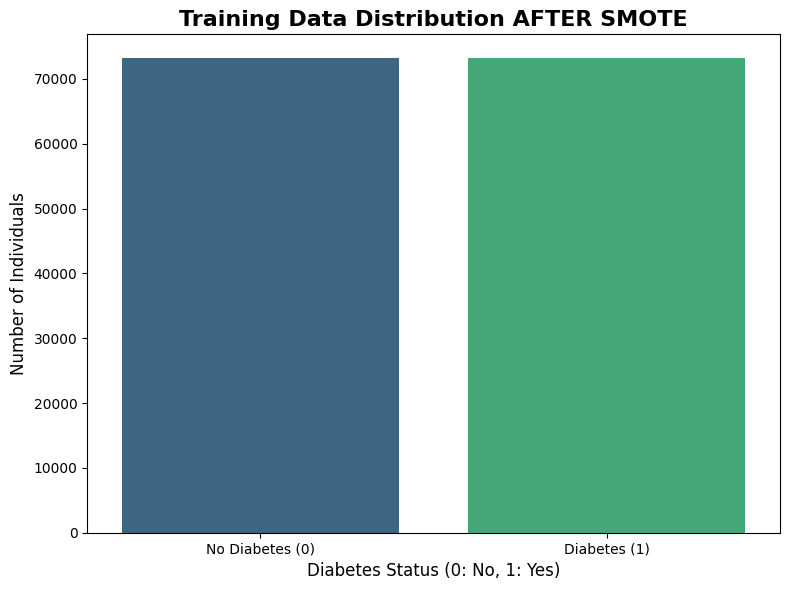


--- 6. Training and Evaluating Models ---

Training model: Logistic Regression...
  Accuracy: 0.8888
  ROC AUC: 0.9629
  Precision (Class 1): 0.4264
  Recall (Class 1): 0.8935
  F1-score (Class 1): 0.5773

Training model: Random Forest...
  Accuracy: 0.9695
  ROC AUC: 0.9621
  Precision (Class 1): 0.9311
  Recall (Class 1): 0.6918
  F1-score (Class 1): 0.7938

Training model: XGBoost...


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:28:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Accuracy: 0.9206
  ROC AUC: 0.9769
  Precision (Class 1): 0.5192
  Recall (Class 1): 0.8900
  F1-score (Class 1): 0.6558

Training model: LightGBM...
[LightGBM] [Info] Number of positive: 6800, number of negative: 73200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085000 -> initscore=-2.376273
[LightGBM] [Info] Start training from score -2.376273


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Accuracy: 0.9152
  ROC AUC: 0.9789
  Precision (Class 1): 0.5006
  Recall (Class 1): 0.9082
  F1-score (Class 1): 0.6455

Training model: CatBoost...
  Accuracy: 0.9241
  ROC AUC: 0.9779
  Precision (Class 1): 0.5322
  Recall (Class 1): 0.8853
  F1-score (Class 1): 0.6648

Training model: SVM (RBF Kernel)...
  Accuracy: 0.8963
  ROC AUC: 0.9688
  Precision (Class 1): 0.4465
  Recall (Class 1): 0.9188
  F1-score (Class 1): 0.6010

Training model: Naive Bayes (with SMOTE)...
  Accuracy: 0.4682
  ROC AUC: 0.9128
  Precision (Class 1): 0.1368
  Recall (Class 1): 0.9900
  F1-score (Class 1): 0.2404

Training model: K-Nearest Neighbors (with SMOTE)...
  Accuracy: 0.9116
  ROC AUC: 0.9119
  Precision (Class 1): 0.4880
  Recall (Class 1): 0.8029
  F1-score (Class 1): 0.6071

Training model: Gradient Boosting (with SMOTE)...
  Accuracy: 0.9544
  ROC AUC: 0.9762
  Precision (Class 1): 0.7119
  Recall (Class 1): 0.7776
  F1-score (Class 1): 0.7433

Training model: MLP Classifier (with SMOTE)...

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


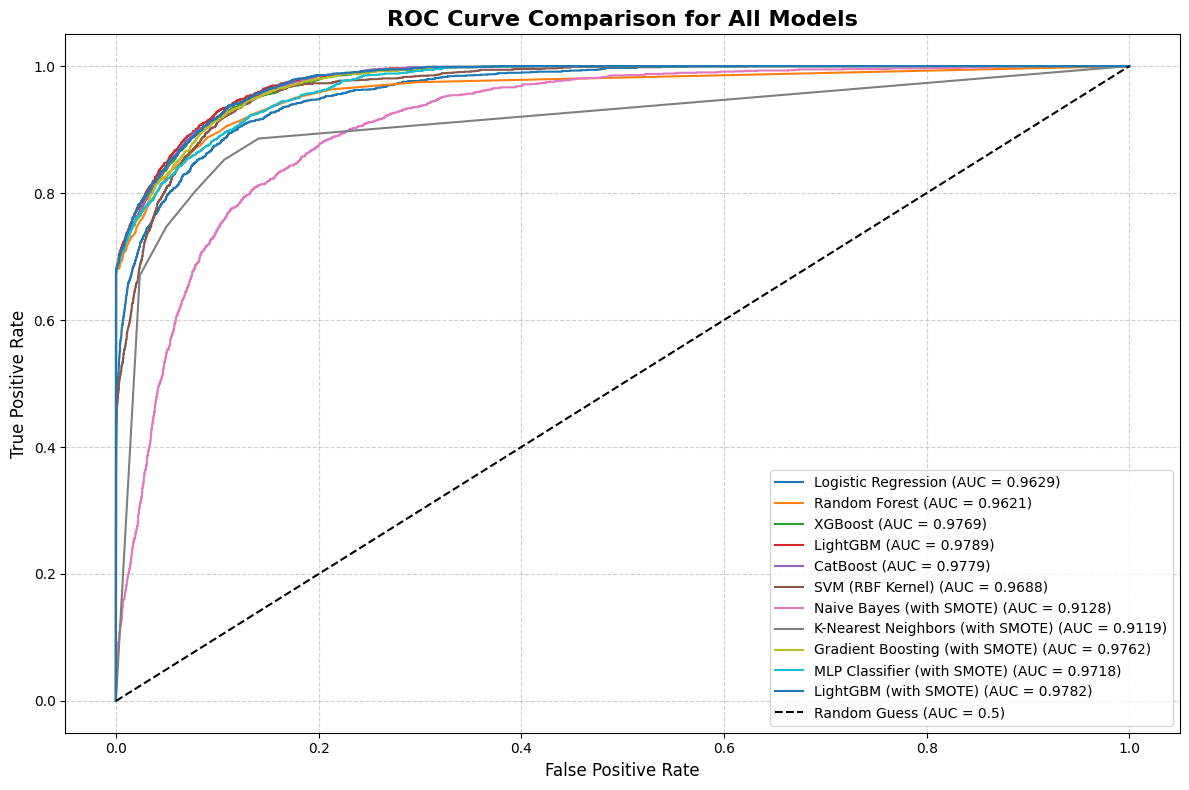


--- Visualizing Logistic Regression ---


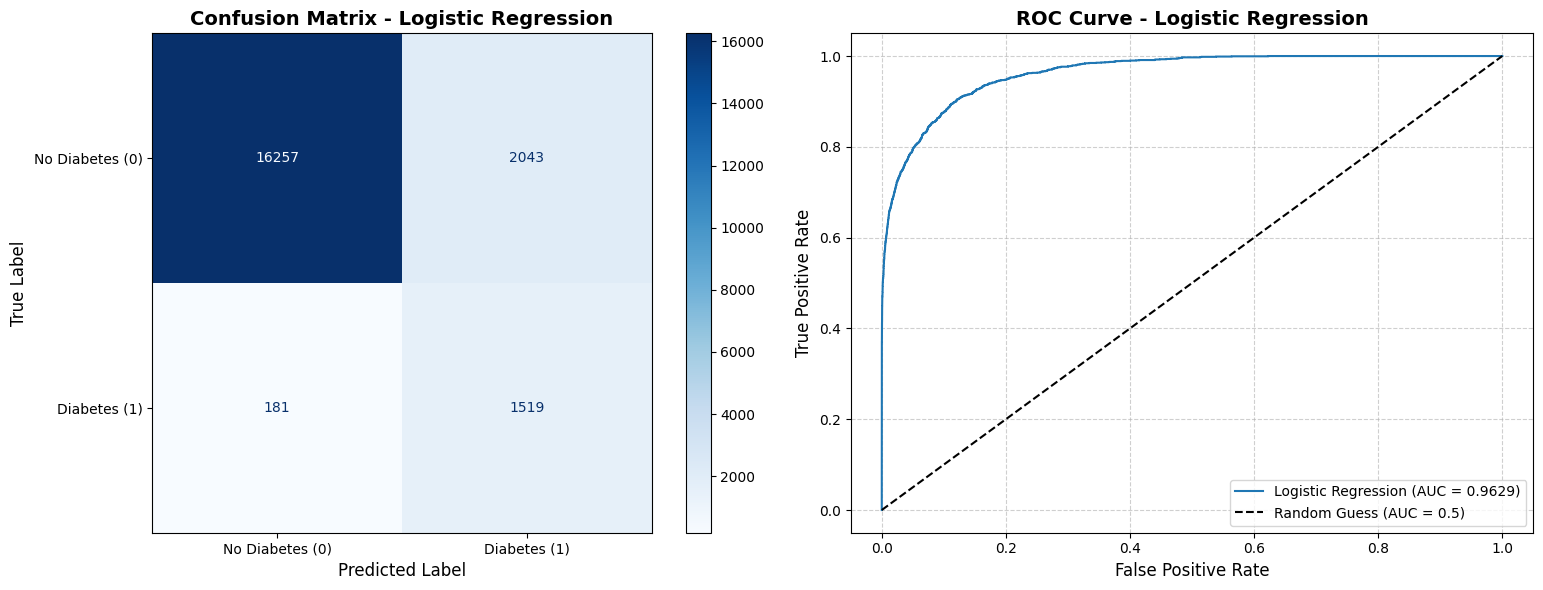


--- Visualizing Random Forest ---


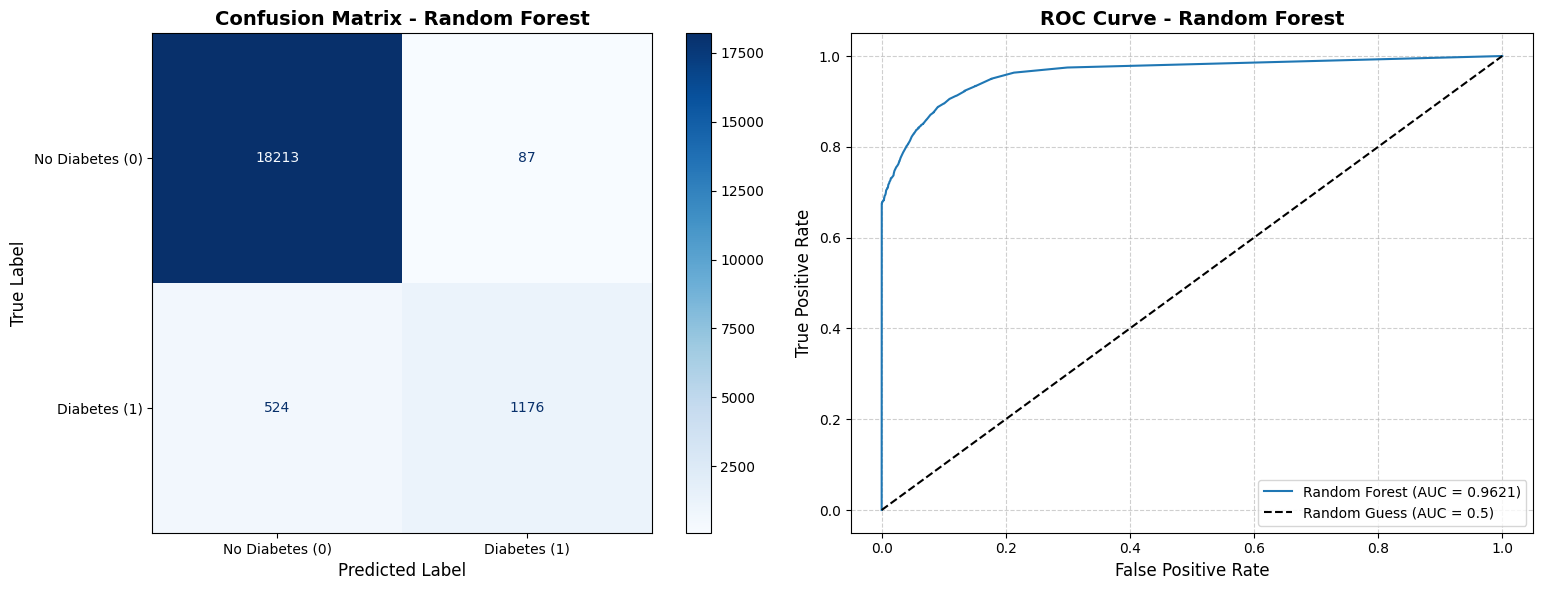


--- Visualizing XGBoost ---


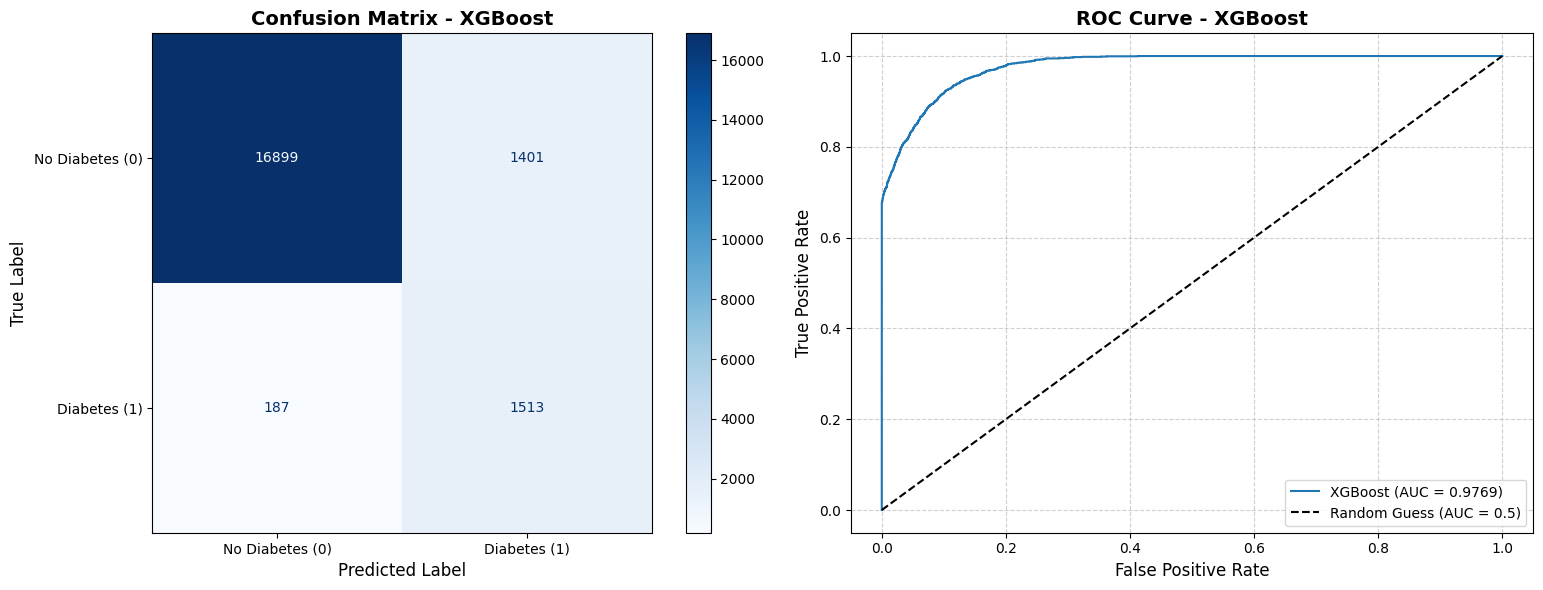


--- Visualizing LightGBM ---


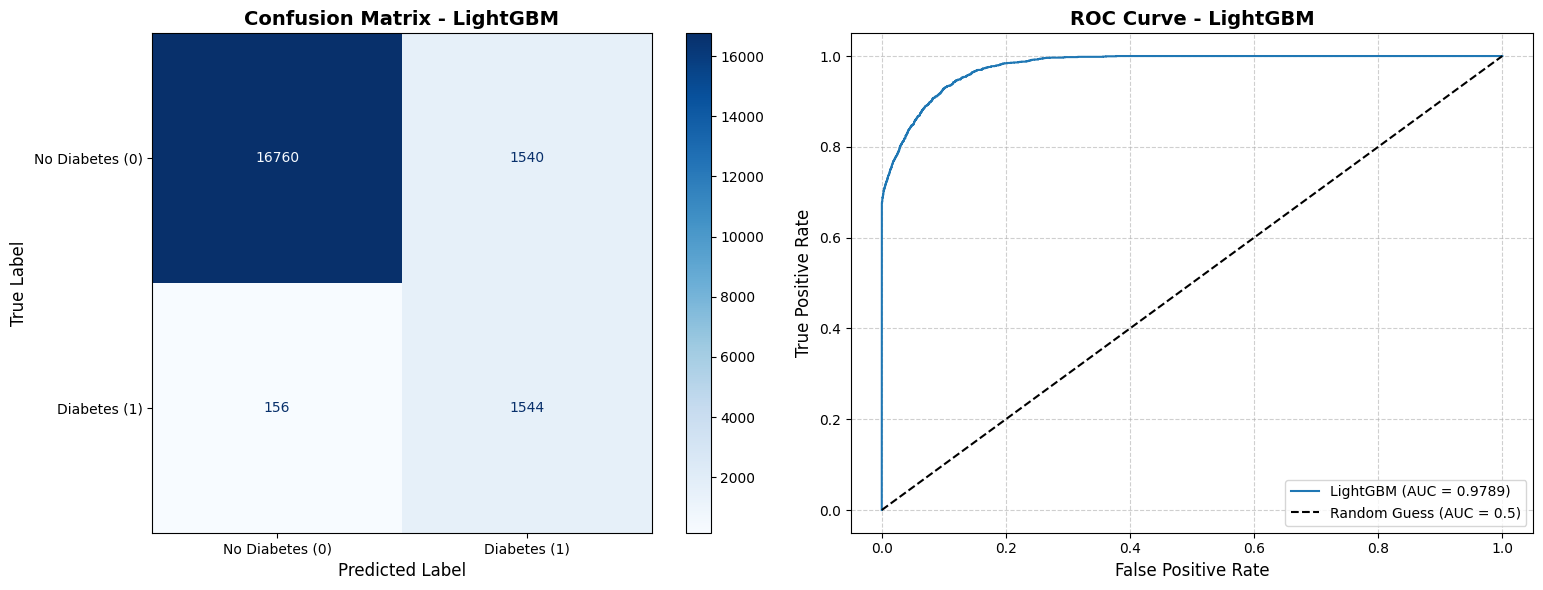


--- Visualizing CatBoost ---


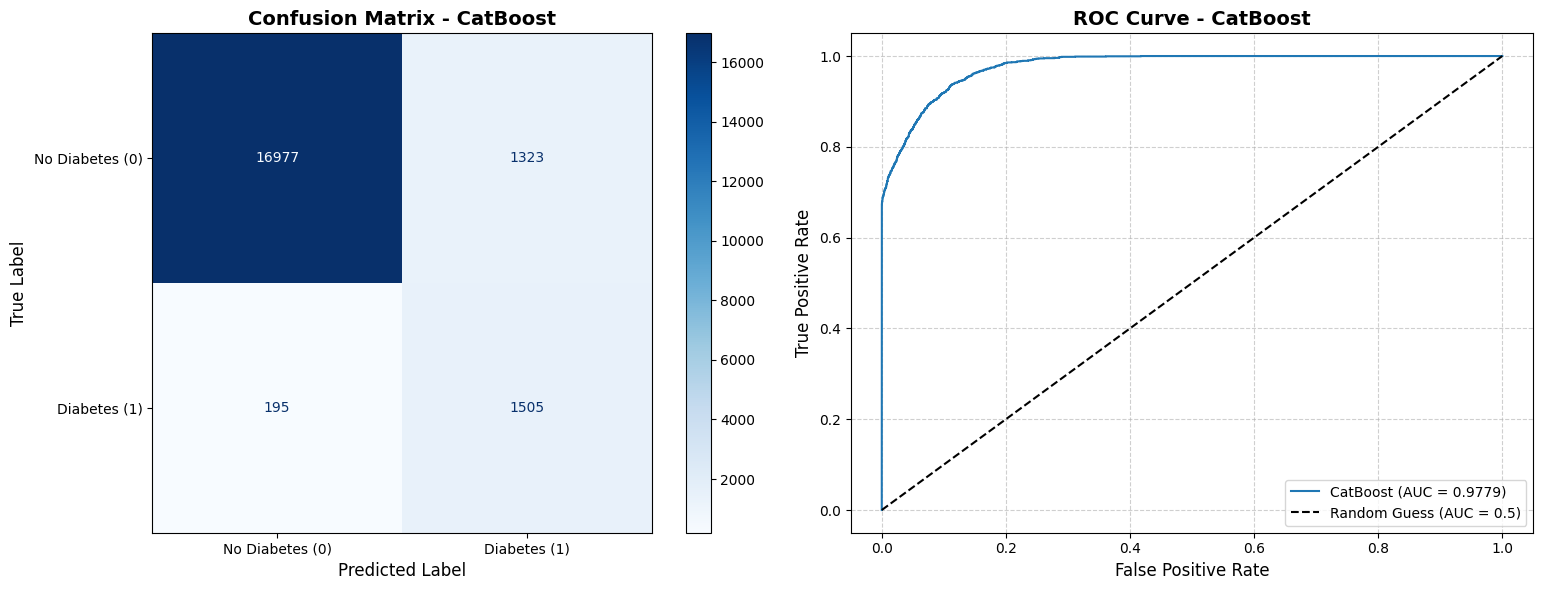


--- Visualizing SVM (RBF Kernel) ---


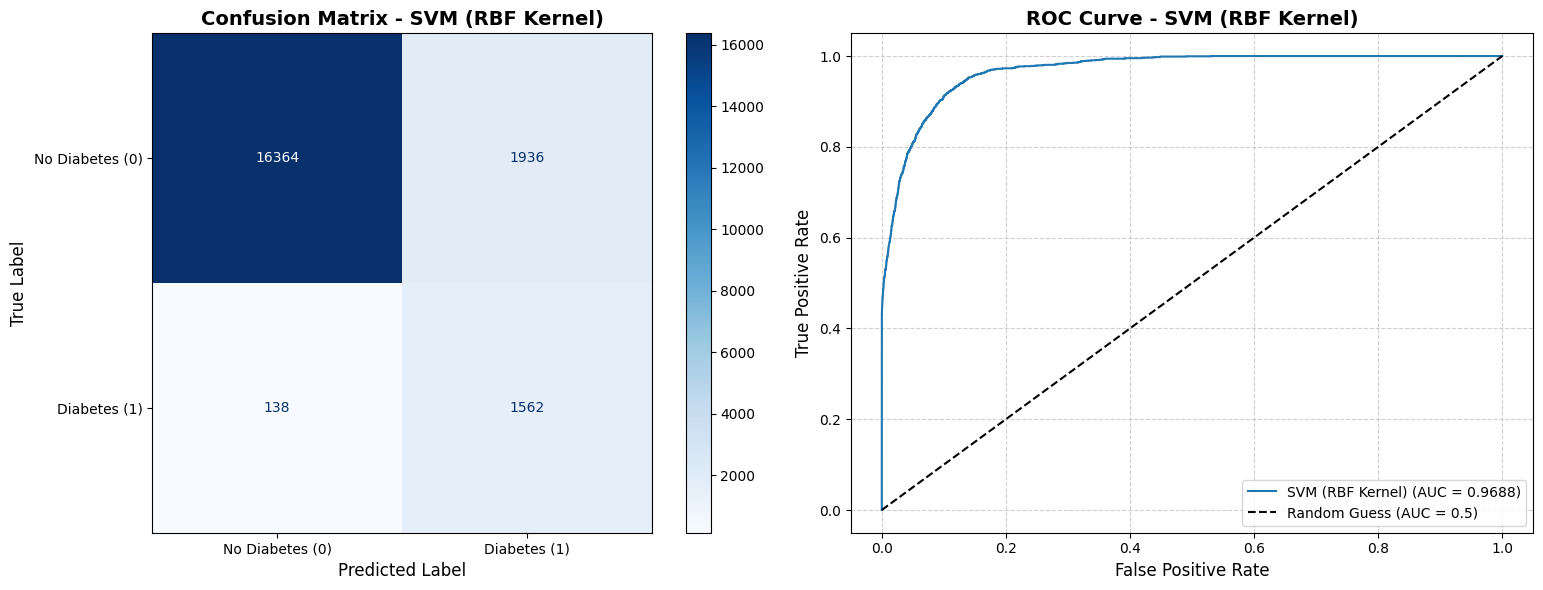


--- Visualizing Naive Bayes (with SMOTE) ---


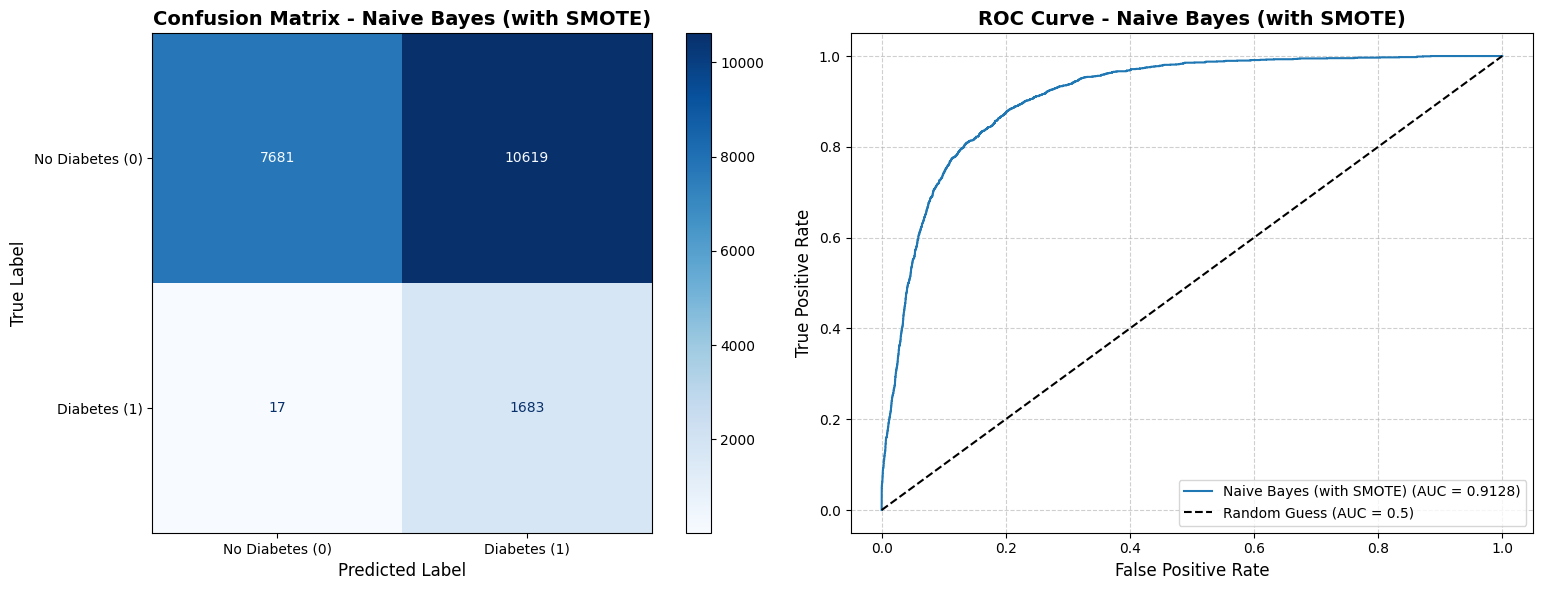


--- Visualizing K-Nearest Neighbors (with SMOTE) ---


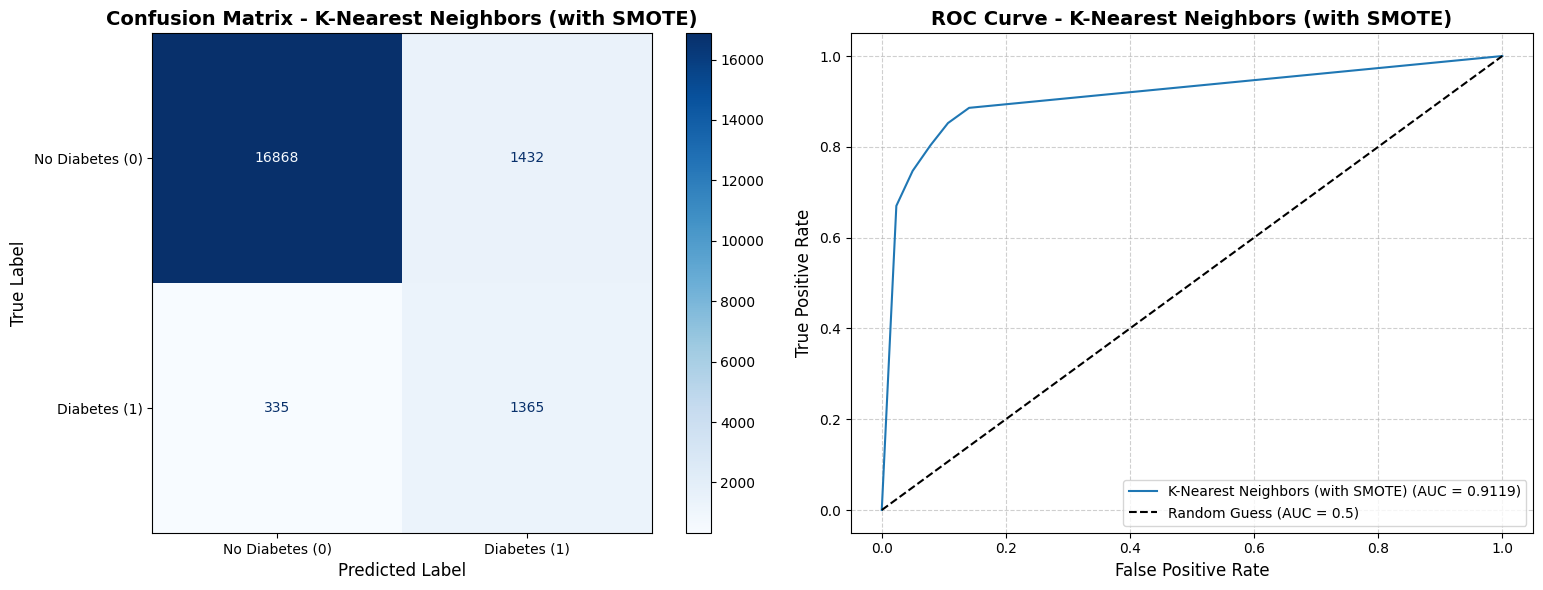


--- Visualizing Gradient Boosting (with SMOTE) ---


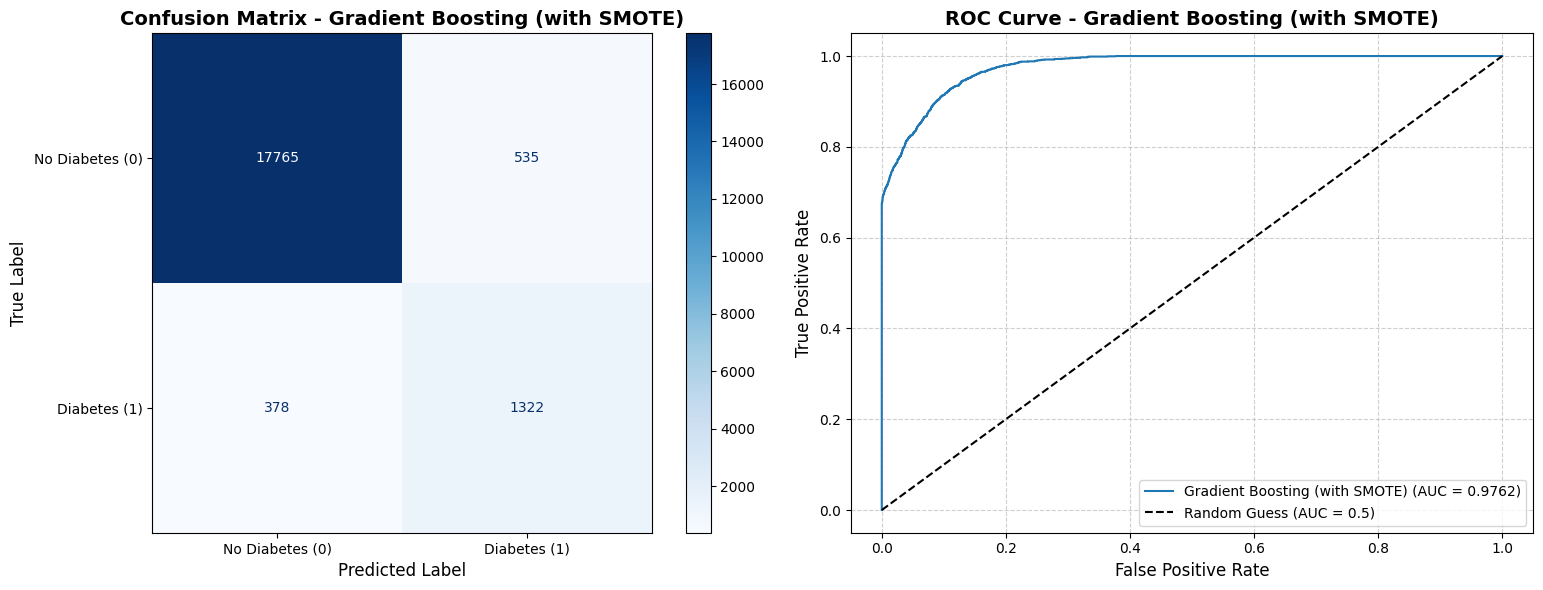


--- Visualizing MLP Classifier (with SMOTE) ---


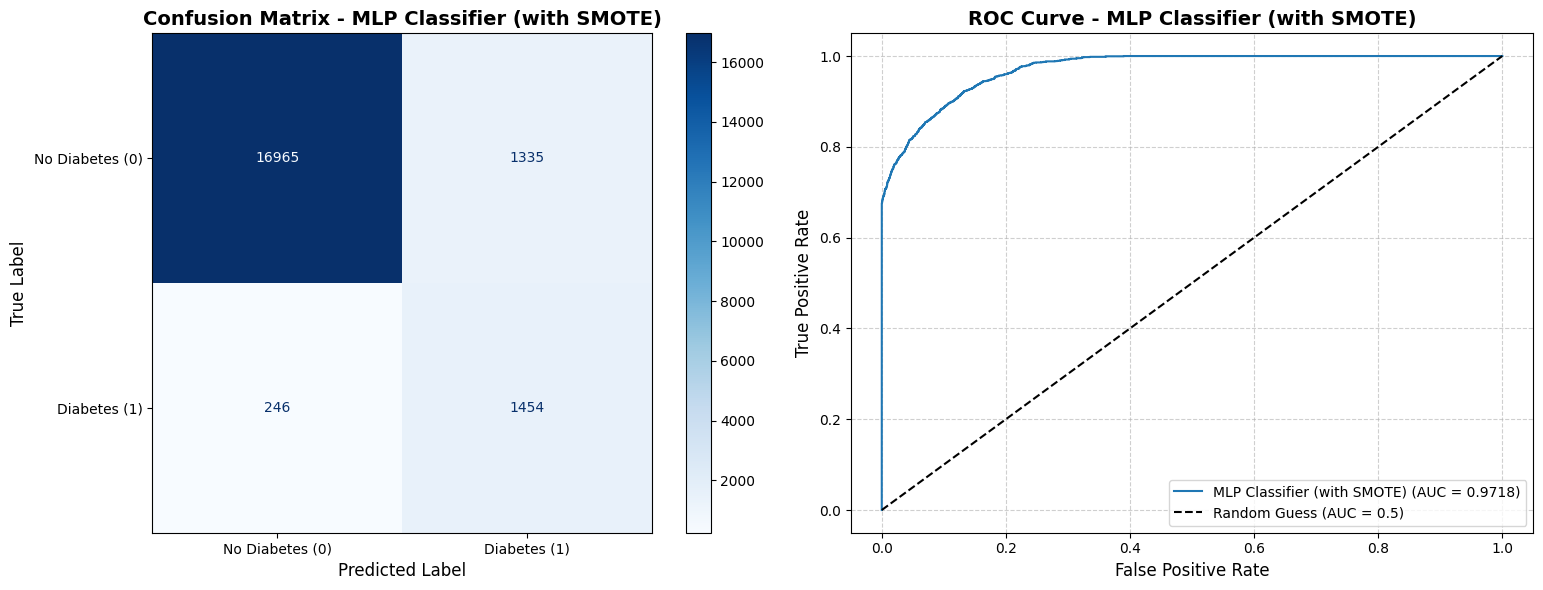


--- Visualizing LightGBM (with SMOTE) ---


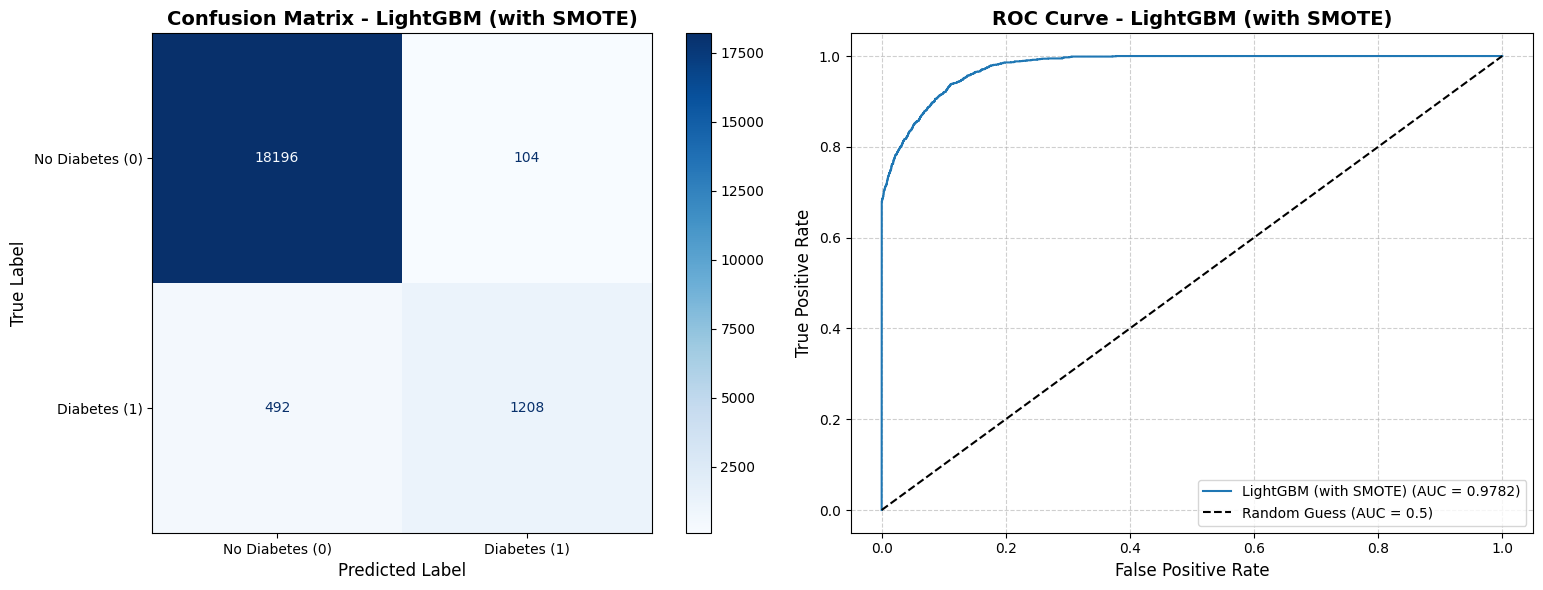


--- SHAP Explanation for the Best Model: LightGBM ---


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


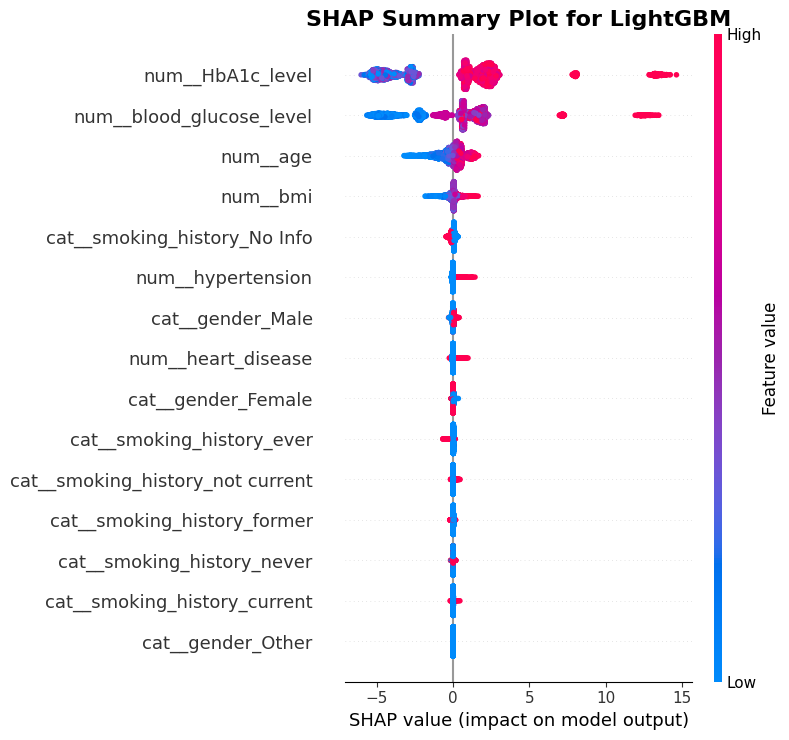


--- Saving the Best Model: LightGBM ---
Model saved as 'LightGBM_model.pkl'


In [2]:


# --- 1. Load Data ---
try:
    df = pd.read_csv("diabetes_prediction_dataset.csv")
    print("--- Data Loaded Successfully ---")
    print(df.head())
    print(df.info())
except FileNotFoundError:
    print("Error: 'diabetes_prediction_dataset.csv' not found.")
    print("Please ensure the CSV file is in the correct directory or provide the full path.")
    print("Generating synthetic data for demonstration as file not found...")
    # Generate synthetic data for demonstration if file not found
    np.random.seed(42)
    n_healthy = 91500
    n_diabetes = 8500
    df = pd.concat([
        pd.DataFrame({
            'gender': np.random.choice(['Female', 'Male'], n_healthy),
            'age': np.random.normal(40, 15, n_healthy).clip(20, 90).astype(int),
            'hypertension': np.random.choice([0, 1], n_healthy, p=[0.9, 0.1]),
            'heart_disease': np.random.choice([0, 1], n_healthy, p=[0.95, 0.05]),
            'smoking_history': np.random.choice(['never', 'No Info', 'former', 'current', 'ever'], n_healthy, p=[0.5, 0.2, 0.1, 0.1, 0.1]),
            'bmi': np.random.normal(25, 5, n_healthy).clip(15, 50),
            'HbA1c_level': np.random.normal(5.5, 0.5, n_healthy).clip(4.0, 7.0),
            'blood_glucose_level': np.random.normal(100, 20, n_healthy).clip(70, 200).astype(int),
            'diabetes': np.zeros(n_healthy).astype(int)
        }),
        pd.DataFrame({
            'gender': np.random.choice(['Female', 'Male'], n_diabetes),
            'age': np.random.normal(60, 10, n_diabetes).clip(30, 90).astype(int),
            'hypertension': np.random.choice([0, 1], n_diabetes, p=[0.3, 0.7]),
            'heart_disease': np.random.choice([0, 1], n_diabetes, p=[0.6, 0.4]),
            'smoking_history': np.random.choice(['current', 'former', 'ever', 'never', 'No Info'], n_diabetes, p=[0.4, 0.3, 0.2, 0.05, 0.05]),
            'bmi': np.random.normal(30, 7, n_diabetes).clip(20, 60),
            'HbA1c_level': np.random.normal(7.5, 0.8, n_diabetes).clip(6.0, 10.0),
            'blood_glucose_level': np.random.normal(200, 50, n_diabetes).clip(140, 300).astype(int),
            'diabetes': np.ones(n_diabetes).astype(int)
        })
    ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

    for col in ['bmi', 'HbA1c_level', 'blood_glucose_level']:
        missing_indices = np.random.choice(df.index, size=int(len(df) * 0.01), replace=False)
        df.loc[missing_indices, col] = np.nan
    missing_cat_indices = np.random.choice(df.index, size=int(len(df) * 0.005), replace=False)
    df.loc[missing_cat_indices, 'smoking_history'] = np.nan

# Drop rows where 'diabetes' target itself is NaN (if any)
df.dropna(subset=["diabetes"], inplace=True) # Ensure target column has no NaNs
X = df.drop(columns="diabetes")
y = df["diabetes"]

# --- 2. Initial Data Analysis (Missing Values and Class Imbalance) ---
print("\n--- Missing Values Count (Before Imputation) ---")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

# --- 3. Column Identification & Preprocessing Pipelines ---
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # sparse_output=False for SHAP compatibility
])

preprocessor = ColumnTransformer([
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# --- 4. Train/Test Split (Stratified is CRUCIAL) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Display Pre-SMOTE Distributions ---
print("\n--- Class Distributions BEFORE SMOTE ---")
print("Training set distribution:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

print("\nTest set distribution:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

# Visualize Class Imbalance (Pre-SMOTE)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x=y_train, palette='viridis', ax=axes[0])
axes[0].set_title('Training Data Distribution (Pre-SMOTE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diabetes Status (0: No, 1: Yes)', fontsize=12)
axes[0].set_ylabel('Number of Individuals', fontsize=12)
axes[0].set_xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])

sns.countplot(x=y_test, palette='viridis', ax=axes[1])
axes[1].set_title('Test Data Distribution (Pre-SMOTE)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Diabetes Status (0: No, 1: Yes)', fontsize=12)
axes[1].set_ylabel('Number of Individuals', fontsize=12)
axes[1].set_xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.tight_layout()
plt.show()


# --- Apply SMOTE for Post-SMOTE Visualization ---
print("\n--- Applying Preprocessing and SMOTE to Training Data for Visualization (Post-SMOTE) ---")
smote_instance_for_plot = SMOTE(sampling_strategy='auto', random_state=42)
smote_pipeline_for_plotting = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", smote_instance_for_plot)
])

# Fit and transform X_train, y_train to get the resampled data for plotting
# Note: X_train_resampled_plot is used only for plotting the distribution,
# the actual models use their internal pipelines which handle SMOTE if specified.
X_train_resampled_plot, y_train_resampled_plot = smote_pipeline_for_plotting.fit_resample(X_train, y_train)

# --- Display Post-SMOTE Distribution for Training Set ---
print("\n--- Class Distribution AFTER SMOTE (Training Set Only) ---")
print("Training set distribution AFTER SMOTE:")
print(y_train_resampled_plot.value_counts())
print(y_train_resampled_plot.value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

# Visualize Class Distribution AFTER SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled_plot, palette='viridis')
plt.title('Training Data Distribution AFTER SMOTE', fontsize=16, fontweight='bold')
plt.xlabel('Diabetes Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.tight_layout()
plt.show()

# --- 5. Define Models with Class Balancing & SMOTE Integration ---
# Calculate scale_pos_weight for tree-based models based on original training data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define the SMOTE instance to be used within ImbPipelines
smote_instance = SMOTE(sampling_strategy='auto', random_state=42)

models_config = {
    "Logistic Regression": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "Random Forest": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "XGBoost": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric="logloss", random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal scale_pos_weight
    },
    "LightGBM": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LGBMClassifier(is_unbalance=True, random_state=42)) # is_unbalance is equivalent to scale_pos_weight
        ]),
        "use_smote_pipeline": False # Uses internal is_unbalance
    },
    "CatBoost": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal auto_class_weights
    },
    "SVM (RBF Kernel)": { # SVM is computationally expensive, reducing max_iter for faster demo
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "Naive Bayes (with SMOTE)": { # GaussianNB doesn't have class_weight, so use SMOTE
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", GaussianNB())
        ]),
        "use_smote_pipeline": True
    },
    "K-Nearest Neighbors (with SMOTE)": { # KNN benefits greatly from balanced data
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", KNeighborsClassifier())
        ]),
        "use_smote_pipeline": True
    },
    "Gradient Boosting (with SMOTE)": { # GradientBoostingClassifier does not have direct class_weight, benefits from SMOTE
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", GradientBoostingClassifier(random_state=42))
        ]),
        "use_smote_pipeline": True
    },
    "MLP Classifier (with SMOTE)": { # MLP can benefit from balanced data
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", MLPClassifier(max_iter=1000, random_state=42)) # Increased max_iter for convergence
        ]),
        "use_smote_pipeline": True
    },
    # Add a LightGBM explicitly with SMOTE as requested
    "LightGBM (with SMOTE)": {
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", LGBMClassifier(random_state=42)) # is_unbalance removed as SMOTE is used
        ]),
        "use_smote_pipeline": True
    }
}

results = {}
best_roc_auc = -1
best_model_name = ""

print("\n--- 6. Training and Evaluating Models ---")
for name, config in models_config.items():
    print(f"\nTraining model: {name}...")
    model_pipeline = config["pipeline"]

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    y_prob = None
    if hasattr(model_pipeline.named_steps["classifier"], "predict_proba"):
        y_prob = model_pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(model_pipeline.named_steps["classifier"], "decision_function"):
        # For SVM without probability=True, decision_function can be used
        y_prob = model_pipeline.named_steps["classifier"].decision_function(
            model_pipeline.named_steps["preprocessor"].transform(X_test) if isinstance(model_pipeline, Pipeline) else model_pipeline.named_steps["preprocessor"].transform(X_test)
        )
        # Normalize decision function to [0,1] for AUC if needed, or ensure it's compatible
        # For AUC, raw decision_function can often be used if higher values mean more positive
        # However, for true probabilities, predict_proba is preferred.
        # If SVC was initialized with probability=False, it won't have predict_proba.
        # This is a fallback; it's better to set probability=True for SVC for reliable AUC.

    # Calculate metrics
    accuracy = (y_test == y_pred).mean()
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    # Store results
    results[name] = {
        "model": model_pipeline,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, target_names=['No Diabetes (0)', 'Diabetes (1)'], output_dict=True, zero_division=0),
        "y_pred": y_pred,
        "y_prob": y_prob
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Precision (Class 1): {precision:.4f}")
    print(f"  Recall (Class 1): {recall:.4f}")
    print(f"  F1-score (Class 1): {f1:.4f}")

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = name

print(f"\n✅ Best Model identified by ROC AUC: {best_model_name} with ROC AUC = {best_roc_auc:.4f}")

# --- 7. Combined Performance Metrics Table ---
print("\n--- Combined Model Performance Metrics ---")

metrics_df_data = []
for name, res in results.items():
    metrics_df_data.append({
        "Model": name,
        "Accuracy": res["accuracy"],
        "ROC AUC": res["roc_auc"],
        "Precision (Class 1)": res["precision"],
        "Recall (Class 1)": res["recall"],
        "F1-Score (Class 1)": res["f1_score"]
    })

performance_df = pd.DataFrame(metrics_df_data)
# Sort by ROC AUC for better comparison
performance_df = performance_df.sort_values(by="ROC AUC", ascending=False).round(4)
print(performance_df.to_string(index=False))


# --- 8. Comprehensive Plotting for Each Model ---

# Overall ROC Curve Comparison
plt.figure(figsize=(12, 8))
for name in results:
    if results[name]["y_prob"] is not None and not np.isnan(results[name]["roc_auc"]):
        fpr, tpr, _ = roc_curve(y_test, results[name]["y_prob"])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.5)")
plt.title("ROC Curve Comparison for All Models", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Individual Confusion Matrices and ROC Curves
for name, res in results.items():
    print(f"\n--- Visualizing {name} ---")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 row, 2 columns

    # Confusion Matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=res["confusion_matrix"],
                                        display_labels=['No Diabetes (0)', 'Diabetes (1)'])
    cm_display.plot(cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {name}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].grid(False) # Remove grid from confusion matrix

    # ROC Curve
    if res["y_prob"] is not None and not np.isnan(res["roc_auc"]):
        # Ensure RocCurveDisplay receives an estimator or precomputed values.
        # It's cleaner to plot directly from precomputed fpr, tpr if model is not directly callable.
        # RocCurveDisplay.from_estimator(res["model"], X_test, y_test, ax=axes[1])
        axes[1].plot(roc_curve(y_test, res["y_prob"])[0], roc_curve(y_test, res["y_prob"])[1], label=f'{name} (AUC = {res["roc_auc"]:.4f})')
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
        axes[1].set_title(f'ROC Curve - {name}', fontsize=14, fontweight='bold')
        axes[1].set_xlabel("False Positive Rate", fontsize=12)
        axes[1].set_ylabel("True Positive Rate", fontsize=12)
        axes[1].legend(fontsize=10)
        axes[1].grid(True, linestyle="--", alpha=0.6)
    else:
        axes[1].text(0.5, 0.5, "ROC Curve Not Applicable\n(No predict_proba or AUC NaN)", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12, color='red')
        axes[1].set_title(f'ROC Curve - {name}', fontsize=14, fontweight='bold')
        axes[1].set_xlabel("False Positive Rate", fontsize=12)
        axes[1].set_ylabel("True Positive Rate", fontsize=12)

    plt.tight_layout()
    plt.show()


# --- 9. SHAP Explanations for the Best Model ---
print(f"\n--- SHAP Explanation for the Best Model: {best_model_name} ---")

best_model_pipeline = results[best_model_name]["model"]

# Extract the classifier and preprocessor from the best model's pipeline
classifier_model_final = None
preprocessor_final = None

if isinstance(best_model_pipeline, ImbPipeline):
    classifier_model_final = best_model_pipeline.named_steps["classifier"]
    preprocessor_final = best_model_pipeline.named_steps["preprocessor"]
elif isinstance(best_model_pipeline, Pipeline):
    classifier_model_final = best_model_pipeline.named_steps["classifier"]
    preprocessor_final = best_model_pipeline.named_steps["preprocessor"]

if classifier_model_final and preprocessor_final:
    # Get feature names after preprocessing
    feature_names_out = preprocessor_final.get_feature_names_out()

    # Determine which explainer to use
    if hasattr(classifier_model_final, "feature_importances_") or \
       isinstance(classifier_model_final, (XGBClassifier, RandomForestClassifier, GradientBoostingClassifier, CatBoostClassifier, LGBMClassifier)):
        # Use TreeExplainer for tree-based models
        explainer = shap.TreeExplainer(classifier_model_final)
        # Ensure X_test is transformed with the same preprocessor as used in the pipeline
        X_test_transformed_shap = preprocessor_final.transform(X_test)
        # Limit the number of samples for SHAP calculation to avoid long runtimes
        sample_size = min(5000, X_test_transformed_shap.shape[0]) # Adjusted sample size for speed
        
        # Convert sparse output from OneHotEncoder if necessary
        if hasattr(X_test_transformed_shap, 'toarray'):
            X_test_transformed_shap = X_test_transformed_shap.toarray()

        shap_values = explainer.shap_values(X_test_transformed_shap[:sample_size])
        shap_features = pd.DataFrame(X_test_transformed_shap[:sample_size], columns=feature_names_out)
    else:
        # Use KernelExplainer for non-tree-based models (e.g., Logistic Regression, SVM, KNN, Naive Bayes, MLP)
        # It requires a background dataset. Use a small sample of preprocessed training data.
        if 'y_train_resampled_plot' in locals() and X_train_resampled_plot is not None:
            # Taking a small sample for KernelExplainer's background data for speed
            background_data = shap.utils.sample(X_train_resampled_plot, 100) # Use 100 samples for background
            explainer = shap.KernelExplainer(classifier_model_final.predict_proba, background_data)
            # Use a subset of the preprocessed X_test for SHAP values
            X_test_transformed_shap = preprocessor_final.transform(X_test)
            sample_size = min(500, X_test_transformed_shap.shape[0]) # Even smaller sample for KernelExplainer's values
            
            # Convert sparse output from OneHotEncoder if necessary
            if hasattr(X_test_transformed_shap, 'toarray'):
                X_test_transformed_shap = X_test_transformed_shap.toarray()

            shap_values = explainer.shap_values(X_test_transformed_shap[:sample_size])
            shap_features = pd.DataFrame(X_test_transformed_shap[:sample_size], columns=feature_names_out)
        else:
            print("Cannot generate SHAP explanation for non-tree models without transformed training data.")
            shap_values = None # Indicate that SHAP values could not be generated

    if shap_values is not None:
        # For binary classification, shap_values is a list of arrays (one for each class).
        # We usually plot for the positive class (class 1).
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap.summary_plot(shap_values[1], shap_features, feature_names=feature_names_out, show=False)
        else: # For single output models or direct feature importances
            shap.summary_plot(shap_values, shap_features, feature_names=feature_names_out, show=False)
        plt.title(f"SHAP Summary Plot for {best_model_name}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("SHAP values could not be generated for plotting.")
else:
    print("Could not retrieve classifier or preprocessor for SHAP explanation.")

# --- 10. Save Best Model ---
if best_model_name:
    print(f"\n--- Saving the Best Model: {best_model_name} ---")
    joblib.dump(results[best_model_name]["model"], f"{best_model_name.replace(' ', '_').replace('(', '').replace(')', '')}_model.pkl")
    print(f"Model saved as '{best_model_name.replace(' ', '_').replace('(', '').replace(')', '')}_model.pkl'")

# Probabilistic prediction section


--- 11. Probabilistic Prediction and Ranking for a New Patient ---

Using the best model: LightGBM for probabilistic prediction.

New Patient's Predicted Probability of Diabetes: 0.9999


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


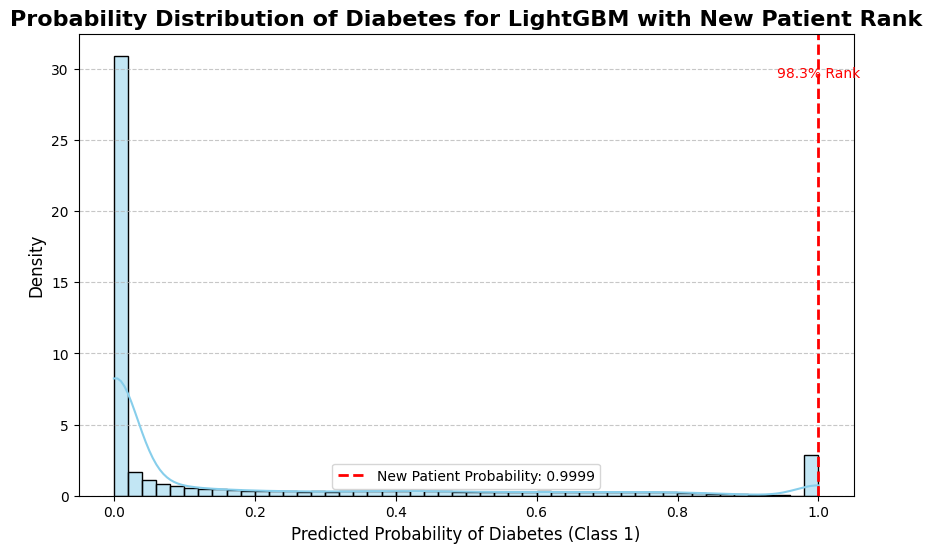


Using the best model: LightGBM for another probabilistic prediction.

New Patient's Predicted Probability of Diabetes: 0.9999


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


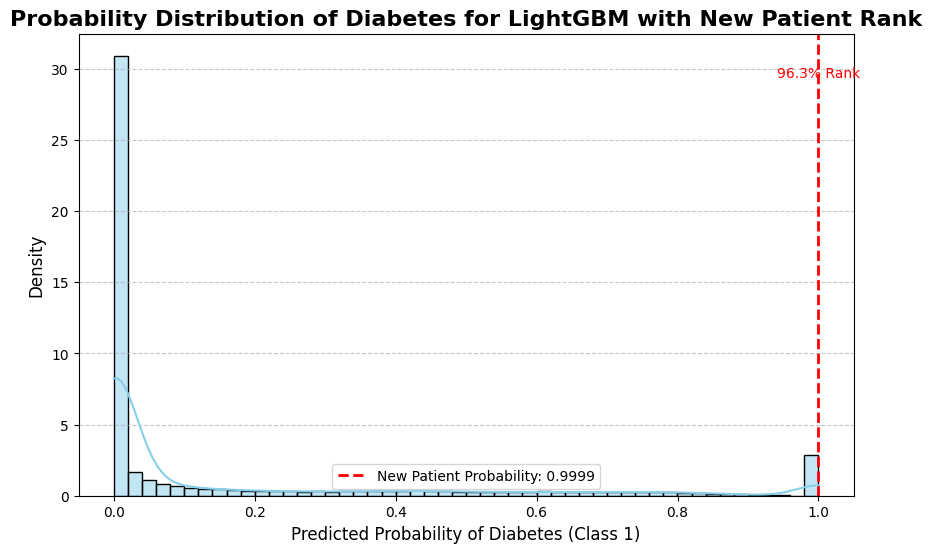

In [3]:
print("\n--- 11. Probabilistic Prediction and Ranking for a New Patient ---")

def predict_and_rank_patient(model_pipeline, X_data_train, new_patient_features, model_name="Model"):
    """
    Predicts the probability for a new patient and plots their rank
    in the distribution of probabilities from the training data.

    Args:
        model_pipeline: The trained scikit-learn pipeline (best_lgb_model or similar).
        X_data_train: The original training features (DataFrame) to get all feature names.
        new_patient_features: A dictionary or pandas Series of the new patient's features.
        model_name: Name of the model for plot title.
    """
    # 1. Prepare new patient data
    new_patient_df = pd.DataFrame([new_patient_features])

    # Ensure all columns from original training data are present, fill missing with NaN
    # This is crucial for the preprocessor
    for col in X_data_train.columns:
        if col not in new_patient_df.columns:
            new_patient_df[col] = np.nan # Or a sensible default/imputation method if known

    # Reorder columns to match the training data used by the preprocessor
    new_patient_df = new_patient_df[X_data_train.columns]

    # 2. Predict probability for the new patient
    new_patient_prob = model_pipeline.predict_proba(new_patient_df)[:, 1][0]
    print(f"\nNew Patient's Predicted Probability of Diabetes: {new_patient_prob:.4f}")

    # 3. Get probabilities for all training data points (or a representative sample)
    # Using X_train for the full distribution as it represents the data the model learned from.
    # Predict probabilities on X_train using the trained model.
    all_probabilities = model_pipeline.predict_proba(X_train)[:, 1]

    # 4. Plot the distribution and mark the new patient's rank
    plt.figure(figsize=(10, 6))
    sns.histplot(all_probabilities, bins=50, kde=True, color='skyblue', edgecolor='black', stat='density')
    plt.axvline(new_patient_prob, color='red', linestyle='--', linewidth=2, label=f'New Patient Probability: {new_patient_prob:.4f}')

    # Calculate percentile rank
    percentile_rank = np.mean(all_probabilities <= new_patient_prob) * 100
    plt.text(new_patient_prob, plt.ylim()[1]*0.9, f'{percentile_rank:.1f}% Rank', color='red', ha='center', va='bottom', fontsize=10)

    plt.title(f'Probability Distribution of Diabetes for {model_name} with New Patient Rank', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Probability of Diabetes (Class 1)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# --- Example Usage of the new function ---

# Define a hypothetical new patient's features (ensure all original columns are included)
# Use your actual column names and example values
# For 'gender', 'smoking_history', ensure the exact categories used in your dataset.
new_patient_example = {
    'gender': 'Female',
    'age': 55,
    'hypertension': 0,
    'heart_disease': 1,
    'smoking_history': 'never',
    'bmi': 32.5,
    'HbA1c_level': 6.8,
    'blood_glucose_level': 180
}

if best_model_name:
    print(f"\nUsing the best model: {best_model_name} for probabilistic prediction.")
    predict_and_rank_patient(
        model_pipeline=results[best_model_name]["model"],
        X_data_train=X_train, # Pass the original training DataFrame to ensure column order and names
        new_patient_features=new_patient_example,
        model_name=best_model_name
    )
else:
    print("No best model found or selected. Cannot perform new patient prediction.")

# You can also test with another patient
new_patient_example_2 = {
    'gender': 'Male',
    'age': 70,
    'hypertension': 1,
    'heart_disease': 1,
    'smoking_history': 'current',
    'bmi': 35.0,
    'HbA1c_level': 6.5,
    'blood_glucose_level': 220
}

if best_model_name:
    print(f"\nUsing the best model: {best_model_name} for another probabilistic prediction.")
    predict_and_rank_patient(
        model_pipeline=results[best_model_name]["model"],
        X_data_train=X_train,
        new_patient_features=new_patient_example_2,
        model_name=best_model_name
    )


In [4]:
# Fine tuning the LightGBM model with SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Define the full pipeline with SMOTE
lgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),                    # Your preprocessing steps (e.g., ColumnTransformer)
    ("smote", SMOTE(random_state=42)),                # Apply SMOTE after preprocessing
    ("classifier", LGBMClassifier(random_state=42))   # Use is_unbalance=False when using SMOTE
])

# Define the hyperparameter search space
param_distributions = {
    "classifier__n_estimators": randint(100, 500),
    "classifier__learning_rate": uniform(0.01, 0.1),  # 0.01 to 0.11
    "classifier__max_depth": randint(3, 10),
    "classifier__num_leaves": randint(15, 60),
    "classifier__min_child_samples": randint(10, 50),
    "classifier__subsample": uniform(0.6, 0.4),
    "classifier__colsample_bytree": uniform(0.6, 0.4)
}

# Use RandomizedSearchCV for hyperparameter tuning
lgb_random_search = RandomizedSearchCV(
    lgb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
    verbose=1,
    random_state=42
)

# Fit on the training data (SMOTE will be applied inside the pipeline during fitting)
lgb_random_search.fit(X_train, y_train)

# Get the best model
best_lgb_model = lgb_random_search.best_estimator_
print("\n✅ Best Parameters Found:")
print(lgb_random_search.best_params_)

# Evaluate on test data
y_pred_lgb = best_lgb_model.predict(X_test)
y_prob_lgb = best_lgb_model.predict_proba(X_test)[:, 1]

print("\n--- Tuned LightGBM Performance ---")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[L

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 1

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-thre

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 976

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, numb

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with pos

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain,

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used 

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 48800, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 97600, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 73200, number of negative: 73200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 146400, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- 13. Probabilistic Prediction and Ranking for a New Patient (using Tuned LightGBM) ---

--- Probabilistic Prediction and Ranking using the TUNED LightGBM Model ---

--- Generating Enhanced Seaborn Plot (Tuned LightGBM) ---

New Patient's Predicted Probability of Diabetes: 1.0000


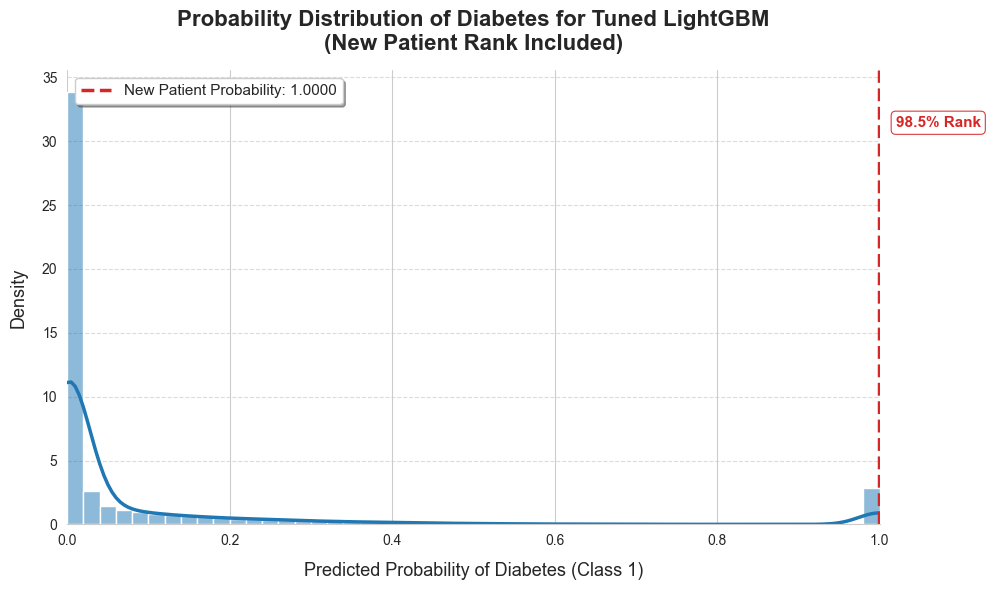


--- Generating Plotly Dynamic Plot (Tuned LightGBM) ---

New Patient's Predicted Probability of Diabetes: 1.0000


/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piyusm/Documents/Github_Repo/SUGAR/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Plotly interactive plot saved as: diabetes_probability_distribution_tuned_lightgbm.html


In [5]:
# Probabilistic Prediction for a New Patient & Distribution Ranking (using Tuned LGBM) ---

print("\n--- 13. Probabilistic Prediction and Ranking for a New Patient (using Tuned LightGBM) ---")

def predict_and_rank_patient_visuals(model_pipeline, X_data_train, new_patient_features, model_name="Model", plot_type="seaborn"):
    """
    Predicts the probability for a new patient and plots their rank
    in the distribution of probabilities from the training data, with enhanced visuals.

    Args:
        model_pipeline: The trained scikit-learn pipeline.
        X_data_train: The original training features (DataFrame) to get all feature names.
        new_patient_features: A dictionary or pandas Series of the new patient's features.
        model_name: Name of the model for plot title.
        plot_type: 'seaborn' for static plot, 'plotly' for interactive plot.
    """
    # 1. Prepare new patient data
    new_patient_df = pd.DataFrame([new_patient_features])

    # Ensure all columns from original training data are present, fill missing with NaN
    for col in X_data_train.columns:
        if col not in new_patient_df.columns:
            new_patient_df[col] = np.nan

    # Reorder columns to match the training data used by the preprocessor
    new_patient_df = new_patient_df[X_data_train.columns]

    # 2. Predict probability for the new patient
    new_patient_prob = model_pipeline.predict_proba(new_patient_df)[:, 1][0]
    print(f"\nNew Patient's Predicted Probability of Diabetes: {new_patient_prob:.4f}")

    # 3. Get probabilities for all training data points
    # IMPORTANT: Use X_train for the distribution, not X_test, as the training set is what the model learned from
    # and represents the general population context.
    all_probabilities = model_pipeline.predict_proba(X_train)[:, 1]

    # 4. Calculate percentile rank
    percentile_rank = np.mean(all_probabilities <= new_patient_prob) * 100

    if plot_type == "seaborn":
        # --- Enhanced Matplotlib/Seaborn Plot ---
        plt.figure(figsize=(10, 6))

        # Set a professional style
        sns.set_style("whitegrid")

        # Use a more appealing color palette
        sns.histplot(
            all_probabilities,
            bins=50,
            kde=True,
            color='#1f77b4',  # A nice blue
            edgecolor='white',
            stat='density',
            line_kws={'linewidth': 2.5, 'color': '#003f5c'} # Darker line for KDE
        )

        # Add the vertical line for the new patient's probability
        plt.axvline(new_patient_prob, color='#d62728', linestyle='--', linewidth=2.5, label=f'New Patient Probability: {new_patient_prob:.4f}')

        # Add percentile rank annotation
        plt.text(
            new_patient_prob + 0.02, # Offset text slightly
            plt.ylim()[1] * 0.9,      # Position near the top
            f'{percentile_rank:.1f}% Rank',
            color='#d62728',
            ha='left',
            va='top',
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='#d62728', lw=0.8, alpha=0.9)
        )

        plt.title(f'Probability Distribution of Diabetes for {model_name}\n(New Patient Rank Included)',
                  fontsize=16, fontweight='bold', pad=15)
        plt.xlabel('Predicted Probability of Diabetes (Class 1)', fontsize=13, labelpad=10)
        plt.ylabel('Density', fontsize=13, labelpad=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(fontsize=11, loc='upper left', frameon=True, shadow=True)
        plt.xlim(0, 1) # Ensure x-axis from 0 to 1

        # Fine-tune grid and borders
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        sns.despine(left=True) # Remove top and right spines

        plt.tight_layout()
        plt.show()

    elif plot_type == "plotly":
        # --- Plotly Dynamic Plot ---

        # Create histogram data
        hist_data = go.Histogram(
            x=all_probabilities,
            nbinsx=50,
            histnorm='density',
            name='Probability Distribution',
            marker_color='rgba(31, 119, 180, 0.6)', # Matching seaborn blue
            marker_line_color='rgba(31, 119, 180, 1.0)',
            marker_line_width=1,
            hovertemplate='Prob Range: %{x}<br>Density: %{y}<extra></extra>'
        )

        # A more robust way to get KDE for Plotly:
        from scipy.stats import gaussian_kde
        kde_values = gaussian_kde(all_probabilities)
        x_kde = np.linspace(0, 1, 200)
        y_kde = kde_values(x_kde)

        kde_trace = go.Scatter(
            x=x_kde,
            y=y_kde,
            mode='lines',
            name='KDE',
            line=dict(color='#003f5c', width=2.5), # Matching seaborn darker line
            hovertemplate='Prob: %{x:.4f}<br>Density: %{y:.4f}<extra></extra>'
        )

        # Create vertical line for new patient probability
        line_trace = go.Scatter(
            x=[new_patient_prob, new_patient_prob],
            y=[0, max(y_kde) * 1.1], # Extend line slightly above max density
            mode='lines',
            name=f'New Patient Probability: {new_patient_prob:.4f}',
            line=dict(color='#d62728', dash='dash', width=2.5),
            hovertemplate=f'New Patient Prob: {new_patient_prob:.4f}<extra></extra>'
        )

        # Create a figure
        fig = go.Figure(data=[hist_data, kde_trace, line_trace])

        # Add text annotation for percentile rank
        fig.add_annotation(
            x=new_patient_prob,
            y=max(y_kde) * 0.95, # Position near the top
            text=f'{percentile_rank:.1f}% Rank',
            showarrow=True,
            arrowhead=2,
            ax=20, # X offset of the arrow end
            ay=-30, # Y offset of the arrow end
            font=dict(
                color='#d62728',
                size=12,
                weight='bold'
            ),
            bgcolor="white",
            bordercolor="#d62728",
            borderwidth=1,
            borderpad=4,
            opacity=0.9
        )


        fig.update_layout(
            title_text=f'<b>Interactive Probability Distribution of Diabetes for {model_name}</b><br><sup>(New Patient Rank Included)</sup>',
            title_x=0.5, # Center title
            title_font_size=18,
            xaxis_title_text='Predicted Probability of Diabetes (Class 1)',
            yaxis_title_text='Density',
            xaxis_range=[0, 1], # Ensure x-axis from 0 to 1
            hovermode="x unified", # Shows all traces' data at a given x-position
            template="plotly_white", # Clean white background
            legend=dict(
                x=0.01, y=0.99, # Position legend top left
                bgcolor="rgba(255,255,255,0.7)",
                bordercolor="Black",
                borderwidth=1
            )
        )

        fig.show()

        # To save the Plotly plot as an HTML file (easily deployable)
        html_filename = f"diabetes_probability_distribution_{model_name.replace(' ', '_').lower()}.html"
        fig.write_html(html_filename)
        print(f"Plotly interactive plot saved as: {html_filename}")

    else:
        print("Invalid plot_type. Please choose 'seaborn' or 'plotly'.")


# --- Example Usage of the new function with Tuned LightGBM ---

# Define a hypothetical new patient's features
new_patient_example = {
    'gender': 'Female',
    'age': 55,
    'hypertension': 0,
    'heart_disease': 1,
    'smoking_history': 'never',
    'bmi': 32.5,
    'HbA1c_level': 6.8,
    'blood_glucose_level': 180
}

# Define a second hypothetical new patient with higher risk
new_patient_example_2 = {
    'gender': 'Male',
    'age': 70,
    'hypertension': 1,
    'heart_disease': 1,
    'smoking_history': 'current',
    'bmi': 35.0,
    'HbA1c_level': 8.5,
    'blood_glucose_level': 220
}

# Use the best_lgb_model obtained from RandomizedSearchCV
print(f"\n--- Probabilistic Prediction and Ranking using the TUNED LightGBM Model ---")

# Generate the Enhanced Seaborn Plot for the first patient
print("\n--- Generating Enhanced Seaborn Plot (Tuned LightGBM) ---")
predict_and_rank_patient_visuals(
    model_pipeline=best_lgb_model, # Use the tuned model
    X_data_train=X_train,
    new_patient_features=new_patient_example,
    model_name="Tuned LightGBM", # Update model name for plot title
    plot_type="seaborn"
)

# Generate the Plotly Dynamic Plot for the first patient
print("\n--- Generating Plotly Dynamic Plot (Tuned LightGBM) ---")
predict_and_rank_patient_visuals(
    model_pipeline=best_lgb_model, # Use the tuned model
    X_data_train=X_train,
    new_patient_features=new_patient_example,
    model_name="Tuned LightGBM", # Update model name for plot title
    plot_type="plotly"
)

# Optional: Generate plots for the second patient as well
# print("\n--- Generating Enhanced Seaborn Plot for Second Patient (Tuned LightGBM) ---")
# predict_and_rank_patient_visuals(
#     model_pipeline=best_lgb_model,
#     X_data_train=X_train,
#     new_patient_features=new_patient_example_2,
#     model_name="Tuned LightGBM",
#     plot_type="seaborn"
# )
# print("\n--- Generating Plotly Dynamic Plot for Second Patient (Tuned LightGBM) ---")
# predict_and_rank_patient_visuals(
#     model_pipeline=best_lgb_model,
#     X_data_train=X_train,
#     new_patient_features=new_patient_example_2,
#     model_name="Tuned LightGBM",
#     plot_type="plotly"
# )

In [6]:
lgb_random_search.best_params_

{'classifier__colsample_bytree': np.float64(0.7666039791481465),
 'classifier__learning_rate': np.float64(0.09832802589188683),
 'classifier__max_depth': 4,
 'classifier__min_child_samples': 37,
 'classifier__n_estimators': 330,
 'classifier__num_leaves': 47,
 'classifier__subsample': np.float64(0.7088528997538541)}

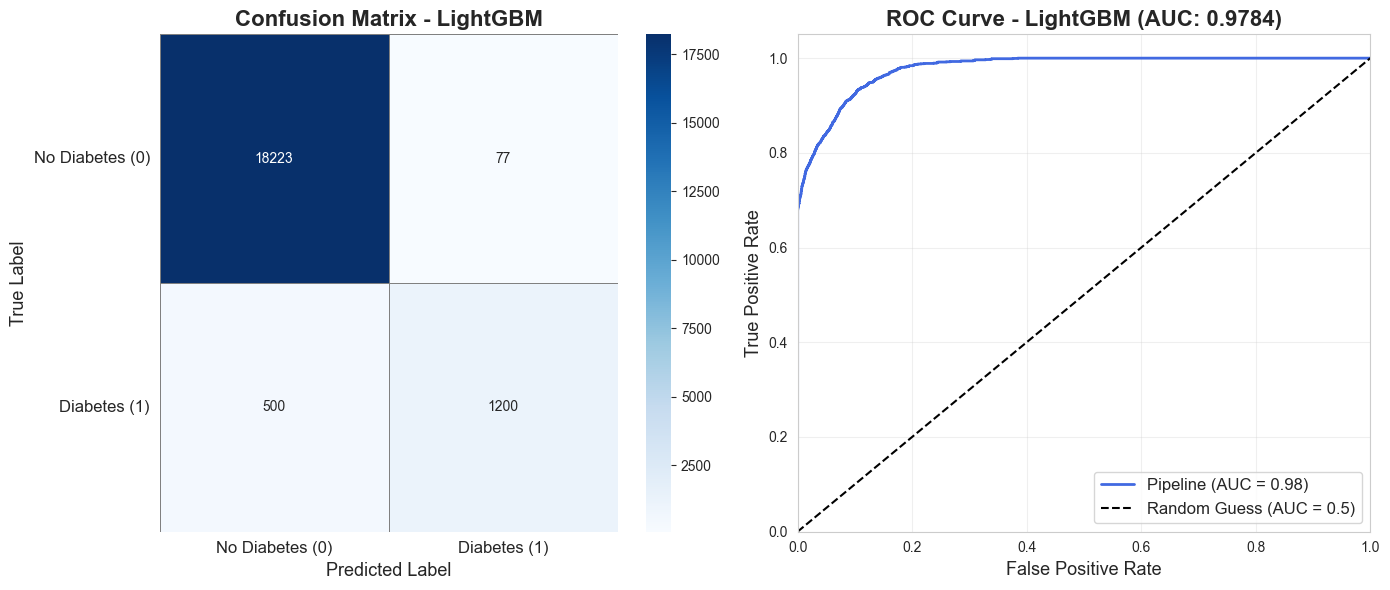

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
fpr, tpr, _ = roc_curve(y_test, y_prob_lgb)
roc_auc = auc(fpr, tpr)

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1️⃣ Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=True, linewidths=0.5, linecolor='gray')
ax[0].set_title('Confusion Matrix - LightGBM', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Predicted Label', fontsize=13)
ax[0].set_ylabel('True Label', fontsize=13)
ax[0].set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'], fontsize=12)
ax[0].set_yticklabels(['No Diabetes (0)', 'Diabetes (1)'], fontsize=12, rotation=0)

# 2️⃣ ROC Curve
ax[1].plot(fpr, tpr, color='royalblue', lw=2, label=f'Pipeline (AUC = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess (AUC = 0.5)')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate', fontsize=13)
ax[1].set_ylabel('True Positive Rate', fontsize=13)
ax[1].set_title(f'ROC Curve - LightGBM (AUC: {roc_auc:.4f})', fontsize=16, fontweight='bold')
ax[1].legend(loc="lower right", fontsize=12)
ax[1].grid(alpha=0.3)

# Tight layout
plt.tight_layout()
plt.show()


In [8]:
# --- START: Added code to save the best model ---
print("\n--- Saving the Optimized LightGBM Model ---")
joblib.dump(best_lgb_model, "optimized_lightgbm_model.pkl")
print("Model saved as 'optimized_lightgbm_model.pkl'")


--- Saving the Optimized LightGBM Model ---
Model saved as 'optimized_lightgbm_model.pkl'
